In [1]:
import sys  
sys.path.insert(1, "..")
from hfsp_scripts import hfsp_functions as hfsp
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy import optimize
import networkx as nx
import pandas as pd

# Define variables for FT1

In [ ]:
temp_sch_1wC = np.array([168])
temp_sch_2wC = np.array([336])
temp_sch_4wC = np.array([672])
temp_sch_1wCW = np.array([20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,8])
temp_sch_2wCW = np.array([20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,16])
temp_sch_4wCW = np.array([20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,
                          20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,20,4,12])
temp_sch_2wC_8hW = np.array([336,8])
temp_sch_2wC_24hW = np.array([336,24])
temp_sch_2wC_72hW = np.array([336,72])
      

# manual prediction/fitting from Rishi's data

p_cold_2d = 0.0003
p_warm_2d = 0.03
p_cold_3d = 0.0004
p_warm_3d = 0.015
p_edge = 1 # we use MR0 to fit the parameters.

p_decay0 = 0
p_decay1 = 0.00003
p_decay2 = 0.00005

# Define g = the SAM template and also define the initial state.

In [ ]:
T_2d = hfsp.create_tissue("../inputs/2d_sam.csv", True)
g = T_2d

# Initial state is alomost 0.94% active nodes (value 10WSD) == around 8 random cells activated in a 3D template.

TENwSD_state = np.zeros((len(g.nodes()),),dtype = int)
TENwSD_state[0] = 1
TENwSD_state[100] = 1
TENwSD_state[200] = 1

hfsp.update_spontaneous(g, jump_state = TENwSD_state)

# Ok, now TENwSD_state is a random state with 0.93% active nodes

In [ ]:
ens_1 = hfsp.ensemble(g, temp_sch_1wC, p_decay1, p_cold_2d, p_warm_2d, p_edge = 1, 
                   rule_code_node = [0,0.5], rule_code_edge = None, ensemble_size = 5, jump_state = TENwSD_state)

In [ ]:
ens_1

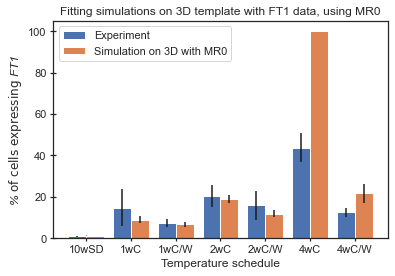

In [3]:
# manual fitting using 3D template.

labels = ['10wSD', '1wC', '1wC/W', '2wC', '2wC/W', '4wC', '4wC/W']

Rishi_data_FT1 = [0.94, 14.78, 7.21, 20.25 , 15.94 , 43.71 , 12.62]
yerr_exp = [0.21, 15.25, 3.29, 9.28, 12, 12, 3.8]

Swanand_simulation_3DMR050 = [0.93,9, 6.74, 19,11.8, 100, 21.8]
yerr_sim_3DMR050 = [0 ,3 , 2, 3.15 , 2.8 , 0 ,8]

Swanand_simulation_2DMR050 = [1,6.47,4.07,20.74,10.01,50, 9]
yerr_sim_2DMR050 = [0,2.5, 1.5 ,8,5,20,4]

x = np.arange(len(labels))  # the label locations
x_axis = np.arange(len(labels))

# Multi bar Chart

sns.set()
sns.set_style("white")
fig, ax = plt.subplots()
ax.bar(x_axis-0.2, Rishi_data_FT1, width = 0.4, yerr = np.divide(yerr_exp, 1.73), label = 'Experiment')
ax.bar(x_axis+0.2, Swanand_simulation_3DMR050 , width=0.4, yerr = np.divide(yerr_sim_3DMR050, 1.73), label = 'Simulation on 3D with MR0')
ax.set_ylabel(r"% $\rm{of\ cells\ expressing}$ FT1", font = "Arial", style = 'italic')
ax.set_xlabel("Temperature schedule")
ax.set_title('Fitting simulations on 3D template with FT1 data, using MR0', font = "Arial")
plt.xticks(x_axis, labels)
ax.tick_params(bottom = True, left = True, direction="inout")
plt.legend(loc='upper left')
# Display
plt.savefig("hfsp_fitting_FT1_3DMR0.png", dpi = 600)

plt.show()